**Explore the data**

In [90]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow
#keras is an abstraction layer over the base TensorFlow API. 
#in most common machine learning scenarios, we can use Keras 
# to simplify the code
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras import optimizers

#the images are in the safari folder
data_path = 'safari/training'

#get the class names
classes = os.listdir(data_path)
classes.sort()
print(classes)

['elephant', 'giraffe', 'lion', 'zebra']


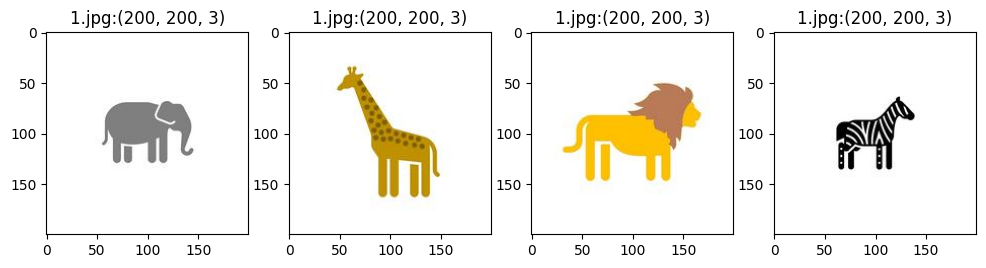

In [91]:
#show the first image in each folder
fig = plt.figure(figsize=(12,12))
i = 0
for sub_dir in os.listdir(data_path):
    i += 1
    img_file = os.listdir(os.path.join(data_path, sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes), i)
    imgplot = plt.imshow(img)
    a.set_title(img_file+ ':' + str(img_shape))
plt.show()


**Prepare the data**

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128, 128
batch_size = 30

print("Getting Data...")

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3)

print("Prepare training dataset...")

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

print("Preparing validation dataset...")

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Prepare training dataset...
Found 280 images belonging to 4 classes.
Preparing validation dataset...
Found 116 images belonging to 4 classes.
Data generators ready


**Define the CNN**

In [93]:
#define the CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

#define the model as a sequence of layers
model = Sequential()

#the input layer accepts an image and applies a convolution that use 32 6x6 filters and rectified linear unit activation function
model.add(Conv2D(32, (6,6), input_shape=train_generator.image_shape, activation='relu'))

#next we will add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size = (2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Flatten the feature maps 
model.add(Flatten())

# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 23, 23, 32)        36896     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 11, 11, 32)      

**Train the model**

In [94]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
9/9 [==============================] - 7s 613ms/step - loss: 1.2226 - accuracy: 0.3560 - val_loss: 0.9588 - val_accuracy: 0.7444
Epoch 2/5
9/9 [==============================] - 6s 629ms/step - loss: 0.8316 - accuracy: 0.7440 - val_loss: 1.1163 - val_accuracy: 0.3778
Epoch 3/5
9/9 [==============================] - 5s 597ms/step - loss: 0.5979 - accuracy: 0.7360 - val_loss: 0.2903 - val_accuracy: 0.9333
Epoch 4/5
9/9 [==============================] - 5s 584ms/step - loss: 0.1880 - accuracy: 0.9520 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 6s 627ms/step - loss: 0.0369 - accuracy: 0.9920 - val_loss: 0.0014 - val_accuracy: 1.0000


**View the loss history**

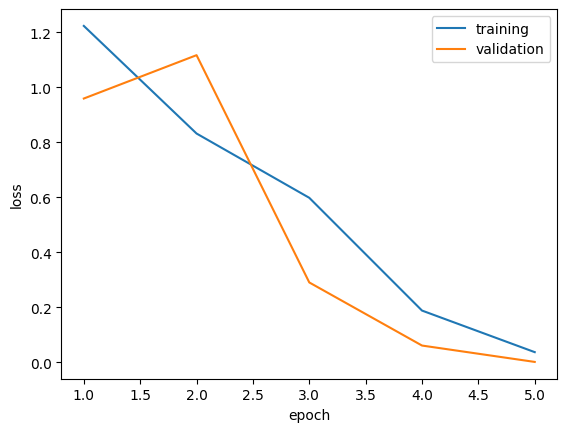

In [95]:
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

**Evaludate the model performance**

Generating predictions from validation data...
1/1 [==============================] - 0s 192ms/step


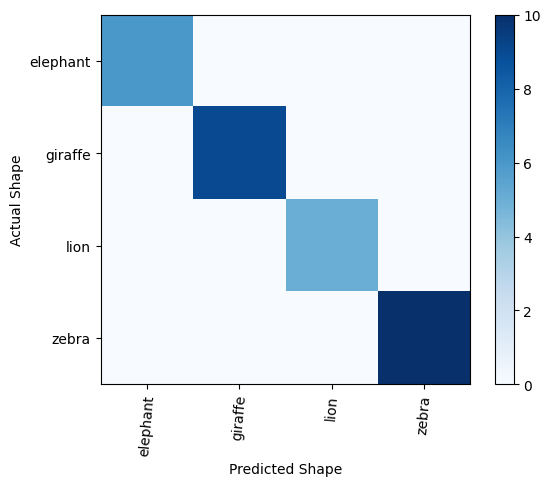

In [96]:
from sklearn.metrics import confusion_matrix

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

**Used the trained model**

In [97]:
# Save the trained model
modelFileName = 'models/safari_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as models/safari_classifier.h5


In [99]:
from random import randint

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

1/1 [==============================] - 0s 121ms/step


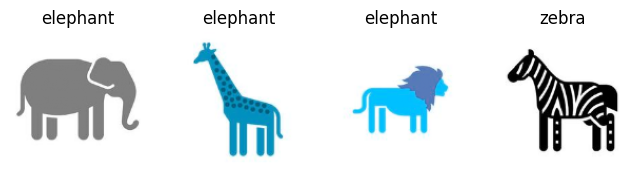

In [108]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

#Load the model
model_path = 'models/safari_classifier.h5'
model = load_model(model_path)

# The images are in the data/shapes folder
test_data_path = 'safari/test'

# Show the test images with predictions
fig = plt.figure(figsize=(8, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize the image
    # Get the image class prediction
    index = np.argmax(model.predict(np.expand_dims(img, axis=0)))
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()